# Notebook to load clustering results and compare them to reference SEDs (such as CWW-Kinney in LePhare)

Created on : Feb. 6, 2023 by Joseph Chevalier

Last update : Feb. 14, 2023 by Joseph Chevalier

## Imports and settings

In [1]:
import os, sys, re
import pickle
import json
import glob
import collections

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.offsetbox
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

from itertools import cycle, islice

from astropy.io import fits
from astropy.table import Table
from scipy import ndimage
from scipy.interpolate import interp1d

# Import the primary photometry classes from rubin_sim.photUtils
from rubin_sim.phot_utils import Bandpass
from rubin_sim.phot_utils import Sed
from rubin_sim.data import get_data_dir
from StudyFors2SED.def_raw_seds import *
#from StudyFors2SED.raw_data_analysis import *

pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/home/joseph/local/dir/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/home/joseph/local/dir/trds/mtab/6452249tm_tmc.fits',
 'thermtable': '/home/joseph/local/dir/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [2]:
def SaveImageInPdf(all_figs,outputfile):
    """
    """
    with PdfPages(outputfile) as pdf:
        for fig in all_figs:
            pdf.savefig(fig)
            plt.close()

In [3]:
root_dir, base_name = os.path.split(os.getcwd())
print(root_dir)

/home/joseph


In [4]:
os.listdir(root_dir)

['.python_history',
 '.condarc',
 'AuxtelEnv',
 'rubin_sim',
 'rubin_sim_data',
 '.stackyter-config.yaml',
 '.landscape',
 '.sudo_as_admin_successful',
 '.gitconfig',
 'Downloads',
 '.conda',
 'PhotoZEnv',
 '.cache',
 '.bash_history',
 '.nedit',
 'anaconda3',
 '.wget-hsts',
 'Spectractor',
 '.motd_shown',
 '.config',
 '.astropy',
 'Anaconda3-2022.10-Linux-x86_64.sh',
 'delegate-contributions-dp02',
 'StackyterEnv',
 'WIP_FORS2',
 '.profile',
 '.jupyter',
 '.ssh',
 '.bash_logout',
 'GMAOMERRA2',
 '.viminfo',
 '.bashrc',
 '.bash_aliases',
 '.mozilla',
 'AuxTelComm',
 '.local',
 'libRadtran',
 'lephare_cosmos',
 'AuxTel_eqw',
 'PhotoZ_PhD',
 'libRadtran-2.0.4.tar.gz',
 'local',
 '.ipython',
 '.dbus']

In [5]:
filename_fits_catalog
t = Table.read(filename_fits_catalog)
t[t["ID"]==106]['z'][0]

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/astropy/io/fits/connect.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


0.6436

In [6]:
print(path_BC)
spec_list = sorted(os.listdir(path_BC))

/home/joseph/PhotoZ_PhD/ResStarlight/BC03N/conf1/HZ4/output_rebuild_BC/full_spectra/


In [7]:
all_numbers = [ int(re.findall('^SPEC(.*)_HZ4_BC[.]txt$',fn)[0]) for fn in spec_list ]
all_numbers = sorted(all_numbers)

## Load LEPHARE results

In [8]:
lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    lephare_res_path = os.environ['LEPHAREWORK']
else:
    lephare_res_path = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = lephare_res_path

In [9]:
os.listdir(os.environ['LEPHAREWORK'])

['output_mass.para',
 'cosmos2020-readcat',
 'SED_FORS2_Kmean15_SL.list',
 'zphot_fors2SL_v4_prevEtCal.out',
 'COSMOS2020.R1_v2.1',
 'SED_AVG_fromSL_FORS2_normed.list',
 'zphot_fors2SL_KinCalClusV2_prevEtCal.out',
 'SED_FORS2_KinCalClus_SL_v2_normed.list',
 '.gitignore',
 'SED_AVG_FORS2.list',
 'SPEC_OUT_outliers_ref',
 'SED_FORS2_Kmean30_SL_normed.list',
 'README.md',
 'figuresLPZ_ultravista.pdf',
 'figuresLPZ.py',
 'zphot_fors2SL_v4N_prevEtCal.out',
 'zphot_vista_adapt_fors2_normed.out',
 'zphot_vista_adapt_fors2.out',
 'BC03_ASCII.list',
 'output.para',
 'zphot_vista_adapt.out',
 'zphot_vista_nothing.out',
 '.git',
 'figuresLPZ_cosmos.pdf',
 '2020-05-28_eric_commands_full_cosmos.dat',
 'SED_FORS2_KinCalClus_SL_v2.list',
 'filt',
 'SCOSMOS.para',
 'ultravista_flux2_zcosmos.in',
 'eric.para',
 'zphot_short.out',
 'SED_FORS2_Kmean30_SL.list',
 'figuresLPZ_cosmos_noBC03.pdf',
 '.ipynb_checkpoints',
 '.gitmodules',
 'outliers_Kmean.in',
 'zphot_fors2SL_v2_calzetti.out',
 'CFHTLS_230506',

In [10]:
########
# PARAMETERS TO SET

# Number of the filter start at 0
selFilt=5   # filter for the selection in mag
uFilt=0
bFilt=1
rFilt=3
zFilt=5
jFilt=8
KsFilt=10

# Array in redshift and mag, isolate extreme values
range_z = np.arange(0., 6.2, 0.5) #[0,1,2,3,6]
z_min, z_max = np.amin(range_z), np.amax(range_z)
range_mag = [15.,22.5,23.5,25,28]
mag_min, mag_max = np.amin(range_mag), np.amax(range_mag)

In [11]:
##################################################
#    CONDITION FOR SELECTION

# Mag use to select the sample
#mag=eval("mag"+str(selFilt))

# condition to select stars
#condstar = (chis<chi)

# condition to select galaxies
#condgal = (~condstar)

def figlpz_zp_zs(zs, zp, mag, runLabel="DUM", magmin=mag_min, magmax=mag_max):
    # General condition to select the galaxies in the expected z/mag range
    cond = (zp>z_min) & (zp<z_max) & (mag>mag_min) & (mag<mag_max)
    
    # condition to select spectroscopic redshifts
    condspec = (zs>0) & (zs<9)
    
    #set the axis
    plt.axis([z_min,z_max,z_min,z_max])

    #new condition with the magnitude range 
    condA = cond & condspec & (mag>magmin) & (mag<magmax)

    # Plot photo-z versus spec-z
    plt.scatter(zs[condA], zp[condA], s=1, color='b',alpha=0.5,marker='s')

    #Check that we have some sources before performing statistics
    Ngal = len( zp[condA])
    if Ngal > 0 :
        #statistics
        arg_bias = zp[condA]-zs[condA]
        arg_std = arg_bias / (1. + zs[condA])
        NMAD = 1.4821 * np.median( abs(arg_std))
        cond_outl = ( abs(arg_std) > 0.15 )
        outl_rate = len(arg_std[cond_outl]) / float(Ngal)
        plt.annotate(r'$N_{gal}  = '+str(Ngal)+'$ \n'+'$\eta  ='+str(100*round(outl_rate,3))+'  \%$\n'+'$ \sigma_{\Delta z /(1+z)}  = '+str(round(NMAD,5))+'$',xy=(0.1*z_max,0.8*z_max),color="black", fontsize=15)

    #Trace the limits 0.15(1+z)
    x_zs = np.array([0,6])
    plt.plot(x_zs, x_zs*1.15+0.15, 'c--')
    plt.plot(x_zs, x_zs, 'r-')
    plt.plot(x_zs, x_zs*0.85-0.15, 'c--')

    #labels
    plt.title("$"+runLabel+"\ run - "+str(mag_min)+" < mag < "+str(mag_max)+"$")
    plt.xlabel('$z_{spec}$', fontsize=18, labelpad=13)
    plt.ylabel('$z_{phot} \; minimum \; \chi^2$', fontsize=18, labelpad=13)

In [12]:
# Loop over the filters
nbFilt=39
magst=""
idmagst=""
# create the string to read the mag
for i in range(nbFilt) :
    magst=magst+",mag"+str(i)
    idmagst=idmagst+","+str(i+20)
# create the string to read the error mag
for i in range(nbFilt) :
    magst=magst+",emag"+str(i)
    idmagst=idmagst+","+str(i+20+nbFilt)
# create the string to read the absolute mag
for i in range(nbFilt) :
    magst=magst+",absmag"+str(i)
    idmagst=idmagst+","+str(i+20+3*nbFilt)
# create the string to read the uncertainties on absolute mag
for i in range(nbFilt) :
    magst=magst+",eabsmag"+str(i)
    idmagst=idmagst+","+str(i+20+4*nbFilt)


# Extract from the ascii file
commandst = "Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis"+magst+",scale,nbFilt,context,zs = np.loadtxt(res_file_path, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"+idmagst+",254,255,256,257), unpack=True )"
# transform the string into a command
print(commandst)

Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis,mag0,mag1,mag2,mag3,mag4,mag5,mag6,mag7,mag8,mag9,mag10,mag11,mag12,mag13,mag14,mag15,mag16,mag17,mag18,mag19,mag20,mag21,mag22,mag23,mag24,mag25,mag26,mag27,mag28,mag29,mag30,mag31,mag32,mag33,mag34,mag35,mag36,mag37,mag38,emag0,emag1,emag2,emag3,emag4,emag5,emag6,emag7,emag8,emag9,emag10,emag11,emag12,emag13,emag14,emag15,emag16,emag17,emag18,emag19,emag20,emag21,emag22,emag23,emag24,emag25,emag26,emag27,emag28,emag29,emag30,emag31,emag32,emag33,emag34,emag35,emag36,emag37,emag38,absmag0,absmag1,absmag2,absmag3,absmag4,absmag5,absmag6,absmag7,absmag8,absmag9,absmag10,absmag11,absmag12,absmag13,absmag14,absmag15,absmag16,absmag17,absmag18,absmag19,absmag20,absmag21,absmag22,absmag23,absmag24,absmag25,absmag26,absmag27,absmag28,absmag29,absmag30,absmag31,absmag32,absmag33,absmag34,absmag35,absmag36,absmag37,absmag38,eabsmag0,eabsmag1,eabsmag2,eabsmag3,eabsmag4,eabsmag5,eabsmag6,eabsmag7,eabsmag8

In [13]:
#res_file_name = 'zphot_vista_adapt_fors2_normed.out'
#res_file_name = 'zphot_fors2SL_v2_calzetti.out'
#res_file_name = 'zphot_fors2SL_v2_prevot.out'
#res_file_name = 'zphot_fors2SL_v3_prevEtCal.out'
#res_file_name = 'zphot_fors2SL_v4N_prevEtCal.out'
res_file_name = 'zphot_fors2SL_KinCalClusV2_prevEtCal.out'
res_file_path = os.path.join(lephare_res_path, res_file_name)

In [14]:
if False:
    with open(res_file_path, 'r') as file:
        print(file.readlines()[30:51])

In [15]:
exec(commandst)

In [16]:
cols_df = commandst.split(' = ')[0]
idx_df, cols_df = cols_df.split(',')[0], cols_df.split(',')[1:]
idx_df

'Id'

In [17]:
np.array(eval(idx_df), dtype='int')

array([    1,     2,     3, ..., 12473, 12474, 12475])

In [18]:
_df_resLePhare = pd.DataFrame(index=np.array(eval(idx_df), dtype='int'),\
                              columns=cols_df)
for col in _df_resLePhare.keys():
    _df_resLePhare[col] = eval(col)
_df_resLePhare

,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,...,eabsmag33,eabsmag34,eabsmag35,eabsmag36,eabsmag37,eabsmag38,scale,nbFilt,context,zs
1,0.19540,0.1987,0.2008,0.2000,0.1728,0.2272,156.4580,20.0,0.0,0.3,...,1.84484,0.54307,0.11306,-1.00000,-1.00000,-1.00000,62.26820,28.0,4.294965e+09,0.2061
2,0.09852,0.0799,0.0828,0.0801,0.0528,0.1073,736.6780,54.0,0.0,0.1,...,1.16541,1.19246,0.44343,1.02332,1.08331,0.17592,6.59730,30.0,2.147484e+09,0.0998
3,0.06000,0.0400,0.0402,0.0401,-999.0000,0.0674,699.1710,16.0,0.0,0.0,...,0.91124,1.48962,0.66692,1.24153,1.20340,0.39413,1.72798,30.0,1.073742e+09,0.5186
4,0.91300,0.9199,0.9201,0.9200,0.8928,0.9472,176.0060,31.0,0.0,0.4,...,0.57703,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,2985.98000,28.0,4.294965e+09,0.9066
5,0.13650,0.1196,0.1239,0.1202,0.0929,0.1474,163.4930,17.0,0.0,0.0,...,1.46207,0.80893,0.48952,-1.00000,-1.00000,-1.00000,1.50180,27.0,3.221224e+09,0.2202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12471,0.58870,0.5919,0.6023,0.5980,0.5708,0.6265,40.3653,57.0,0.0,0.3,...,0.39094,0.20042,-1.00000,-1.00000,-1.00000,-1.00000,22.91010,27.0,2.147482e+09,0.6665
12472,1.33000,1.3188,1.3239,1.3202,1.2929,1.3474,56206.7000,73.0,0.0,0.0,...,1.65016,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,52.38830,28.0,4.294965e+09,0.2832
12473,0.49770,0.4797,0.4856,0.4805,0.4530,0.5077,131.5390,72.0,0.0,0.1,...,1.08610,0.27035,-1.00000,-1.00000,-1.00000,-1.00000,36.70430,28.0,4.294965e+09,0.5028
12474,0.35040,0.3591,0.3603,0.3600,0.3328,0.3872,72.3599,36.0,0.0,0.2,...,2.21216,0.45984,0.86897,-1.00000,-1.00000,-1.00000,50.68470,28.0,4.294965e+09,0.3442


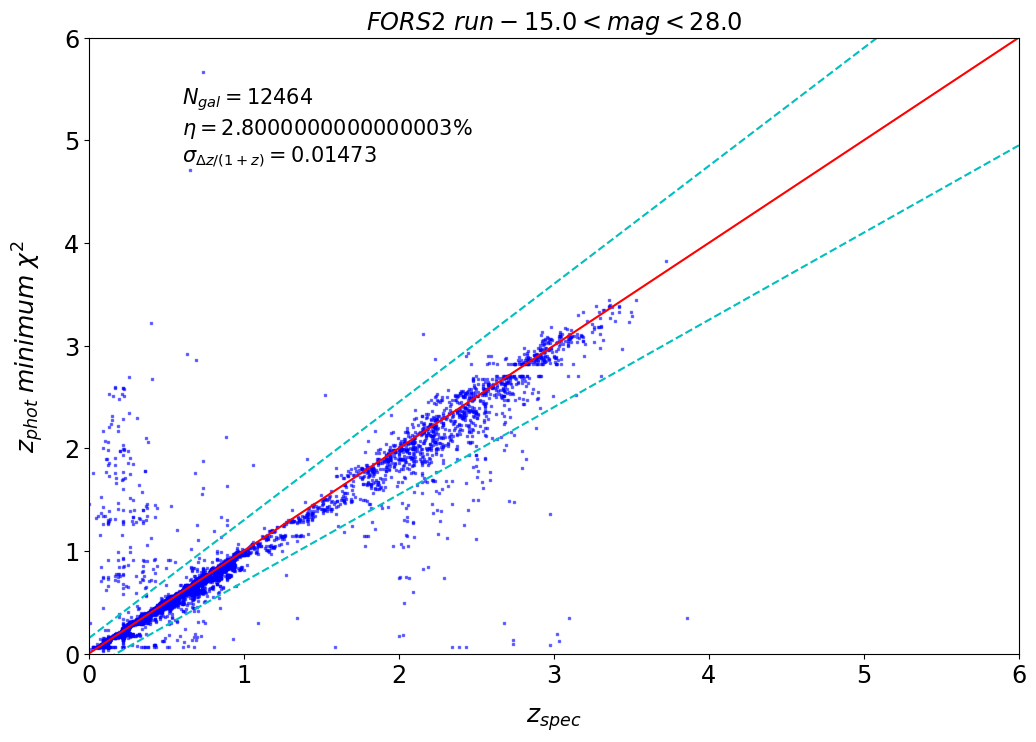

In [19]:
figlpz_zp_zs(_df_resLePhare['zs'], _df_resLePhare['zp'], _df_resLePhare["mag"+str(selFilt)],\
             runLabel='FORS2', magmin=mag_min, magmax=mag_max)

In [20]:
_df_resLePhare['Outlier'] = (np.abs(_df_resLePhare['zp'] - _df_resLePhare['zs']) >= 0.15*(1+_df_resLePhare['zs']))
_df_resLePhare['zs_Outlier'] = _df_resLePhare['zs'][_df_resLePhare['Outlier']]
_df_resLePhare['zp_Outlier'] = _df_resLePhare['zp'][_df_resLePhare['Outlier']]

_insiders = [not b for b in np.array(_df_resLePhare['Outlier'])]
_df_resLePhare['zs_Insider'] = _df_resLePhare['zs'][_insiders]
_df_resLePhare['zp_Insider'] = _df_resLePhare['zp'][_insiders]

/tmp/ipykernel_1481/3277909616.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df_resLePhare['Outlier'] = (np.abs(_df_resLePhare['zp'] - _df_resLePhare['zs']) >= 0.15*(1+_df_resLePhare['zs']))
/tmp/ipykernel_1481/3277909616.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df_resLePhare['zs_Outlier'] = _df_resLePhare['zs'][_df_resLePhare['Outlier']]
/tmp/ipykernel_1481/3277909616.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [21]:
for gal in _df_resLePhare.index:
    _sel = _df_resLePhare.loc[gal, f'mag{selFilt}']
    if _sel < mag_min:
        _df_resLePhare.loc[gal, 'SEL_MAG'] = f'mag<{mag_min}'
    elif _sel >= mag_max:
        _df_resLePhare.loc[gal, 'SEL_MAG'] = f'{mag_max}<=mag'
    else:
        for m,M in zip(range_mag[:-1], range_mag[1:]):
            if _sel >= m and _sel < M :
                _df_resLePhare.loc[gal, 'SEL_MAG'] = f'{m}<=mag<{M}'

/tmp/ipykernel_1481/494599525.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df_resLePhare.loc[gal, 'SEL_MAG'] = f'{m}<=mag<{M}'


In [22]:
for gal in _df_resLePhare.index:
    _sel = _df_resLePhare.loc[gal, 'zs']
    if _sel < z_min:
        _df_resLePhare.loc[gal, 'SEL_ZS'] = f'z-spec<{z_min}'
    elif _sel >= z_max:
        _df_resLePhare.loc[gal, 'SEL_ZS'] = f'{z_max}<=z-spec'
    else:
        for z,Z in zip(range_z[:-1], range_z[1:]):
            if _sel >= z and _sel < Z :
                _df_resLePhare.loc[gal, 'SEL_ZS'] = f'{z}<=z-spec<{Z}'

/tmp/ipykernel_1481/673555629.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df_resLePhare.loc[gal, 'SEL_ZS'] = f'{z}<=z-spec<{Z}'


## Save datafram as pickle

In [23]:
df_resLePhare = _df_resLePhare.copy()
df_resLePhare.to_pickle('df_'+res_file_name.split('.')[0]+'.pkl')

## Similar approach with COSMOS ref data

In [24]:
cos_file_name = 'zphot_vista_adapt_noBC03.out'
cos_file_path = os.path.join(lephare_res_path, cos_file_name)

In [25]:
# Extract from the ascii file
commandst = "Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis"+magst+",scale,nbFilt,context,zs = np.loadtxt(cos_file_path, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"+idmagst+",254,255,256,257), unpack=True )"
# transform the string into a command
print(commandst)

Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis,mag0,mag1,mag2,mag3,mag4,mag5,mag6,mag7,mag8,mag9,mag10,mag11,mag12,mag13,mag14,mag15,mag16,mag17,mag18,mag19,mag20,mag21,mag22,mag23,mag24,mag25,mag26,mag27,mag28,mag29,mag30,mag31,mag32,mag33,mag34,mag35,mag36,mag37,mag38,emag0,emag1,emag2,emag3,emag4,emag5,emag6,emag7,emag8,emag9,emag10,emag11,emag12,emag13,emag14,emag15,emag16,emag17,emag18,emag19,emag20,emag21,emag22,emag23,emag24,emag25,emag26,emag27,emag28,emag29,emag30,emag31,emag32,emag33,emag34,emag35,emag36,emag37,emag38,absmag0,absmag1,absmag2,absmag3,absmag4,absmag5,absmag6,absmag7,absmag8,absmag9,absmag10,absmag11,absmag12,absmag13,absmag14,absmag15,absmag16,absmag17,absmag18,absmag19,absmag20,absmag21,absmag22,absmag23,absmag24,absmag25,absmag26,absmag27,absmag28,absmag29,absmag30,absmag31,absmag32,absmag33,absmag34,absmag35,absmag36,absmag37,absmag38,eabsmag0,eabsmag1,eabsmag2,eabsmag3,eabsmag4,eabsmag5,eabsmag6,eabsmag7,eabsmag8

In [26]:
exec(commandst)

In [27]:
cols_df = commandst.split(' = ')[0]
idx_df, cols_df = cols_df.split(',')[0], cols_df.split(',')[1:]
_df_cosLePhare = pd.DataFrame(index=np.array(eval(idx_df), dtype='int'),\
                              columns=cols_df)

for col in _df_cosLePhare.keys():
    _df_cosLePhare[col] = eval(col)

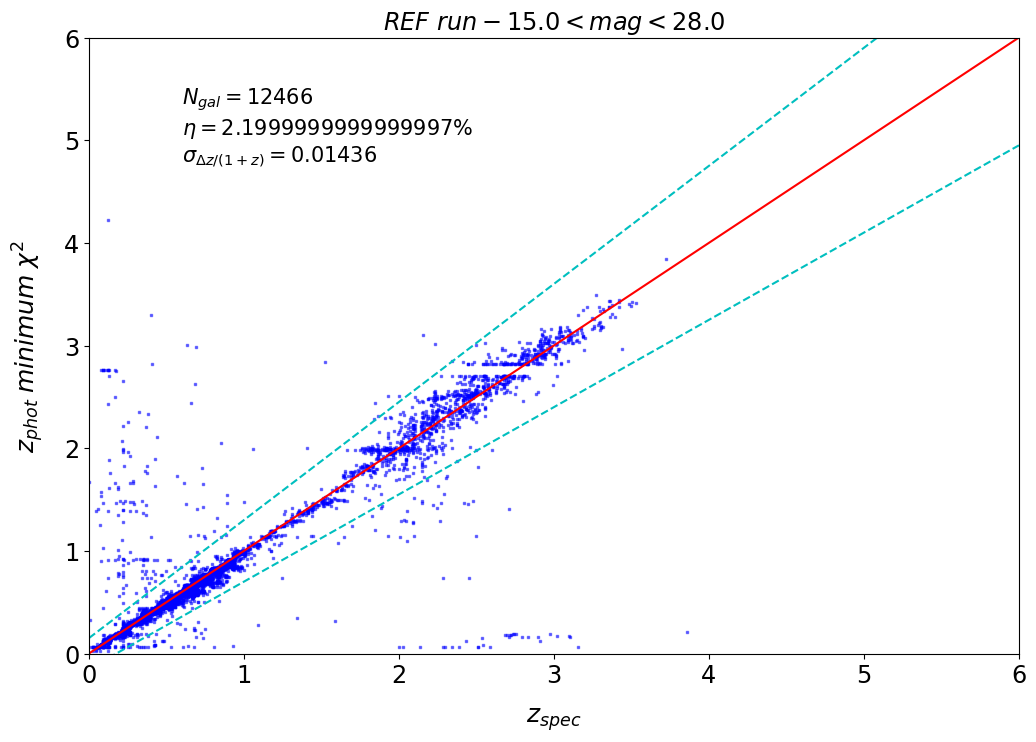

In [28]:
figlpz_zp_zs(_df_cosLePhare['zs'], _df_cosLePhare['zp'], _df_cosLePhare["mag"+str(selFilt)],\
             runLabel='REF', magmin=mag_min, magmax=mag_max)

In [29]:
_df_cosLePhare['Outlier'] = (np.abs(_df_cosLePhare['zp'] - _df_cosLePhare['zs']) >= 0.15*(1+_df_cosLePhare['zs']))
_df_cosLePhare['zs_Outlier'] = _df_cosLePhare['zs'][_df_cosLePhare['Outlier']]
_df_cosLePhare['zp_Outlier'] = _df_cosLePhare['zp'][_df_cosLePhare['Outlier']]

_insiders = [not b for b in np.array(_df_cosLePhare['Outlier'])]
_df_cosLePhare['zs_Insider'] = _df_cosLePhare['zs'][_insiders]
_df_cosLePhare['zp_Insider'] = _df_cosLePhare['zp'][_insiders]

for gal in _df_cosLePhare.index:
    _sel = _df_cosLePhare.loc[gal, f'mag{selFilt}']
    if _sel < mag_min:
        _df_cosLePhare.loc[gal, 'SEL_MAG'] = f'mag<{mag_min}'
    elif _sel >= mag_max:
        _df_cosLePhare.loc[gal, 'SEL_MAG'] = f'{mag_max}<=mag'
    else:
        for m,M in zip(range_mag[:-1], range_mag[1:]):
            if _sel >= m and _sel < M :
                _df_cosLePhare.loc[gal, 'SEL_MAG'] = f'{m}<=mag<{M}'

for gal in _df_cosLePhare.index:
    _sel = _df_cosLePhare.loc[gal, 'zs']
    if _sel < z_min:
        _df_cosLePhare.loc[gal, 'SEL_ZS'] = f'z-spec<{z_min}'
    elif _sel >= z_max:
        _df_cosLePhare.loc[gal, 'SEL_ZS'] = f'{z_max}<=z-spec'
    else:
        for z,Z in zip(range_z[:-1], range_z[1:]):
            if _sel >= z and _sel < Z :
                _df_cosLePhare.loc[gal, 'SEL_ZS'] = f'{z}<=z-spec<{Z}'

/tmp/ipykernel_1481/1337443637.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df_cosLePhare['Outlier'] = (np.abs(_df_cosLePhare['zp'] - _df_cosLePhare['zs']) >= 0.15*(1+_df_cosLePhare['zs']))
/tmp/ipykernel_1481/1337443637.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df_cosLePhare['zs_Outlier'] = _df_cosLePhare['zs'][_df_cosLePhare['Outlier']]
/tmp/ipykernel_1481/1337443637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [30]:
df_cosLePhare = _df_cosLePhare.copy()
df_cosLePhare.to_pickle('df_'+cos_file_name.split('.')[0]+'.pkl')

## Plot relevant data - outliers
### And compare vs. COSMOS

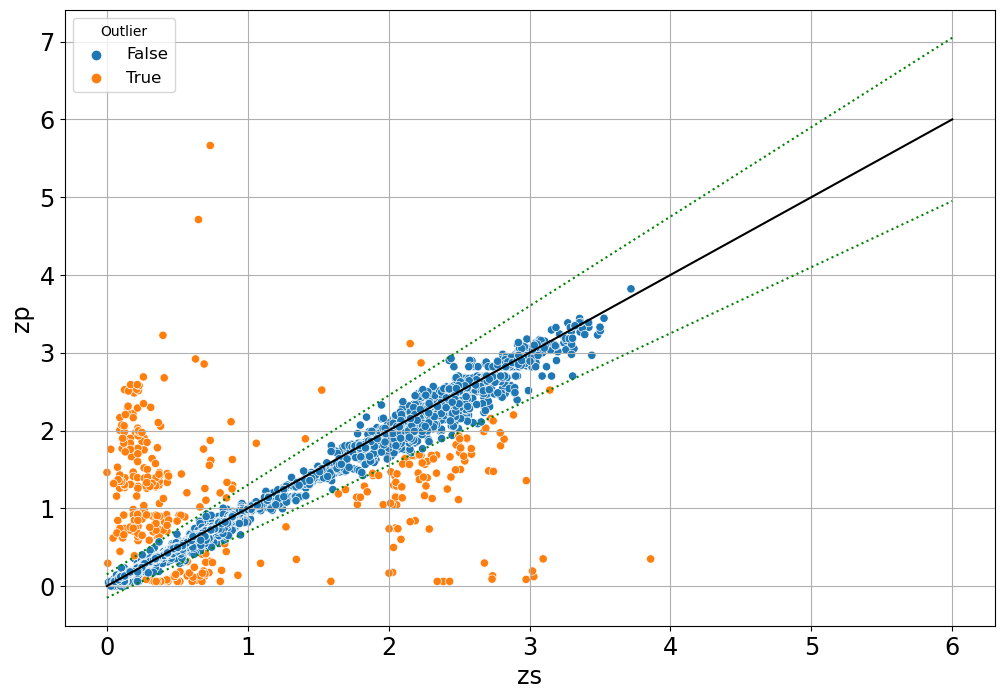

In [31]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_resLePhare, x='zs', y='zp', hue='Outlier', ax=a)
a.plot(np.arange(0,7), np.arange(0,7)+0.15*(1+np.arange(0,7)), c='g', ls=':')
a.plot(np.arange(0,7), np.arange(0,7)-0.15*(1+np.arange(0,7)), c='g', ls=':')
a.plot(np.arange(0,7), np.arange(0,7), c='k')
a.grid()

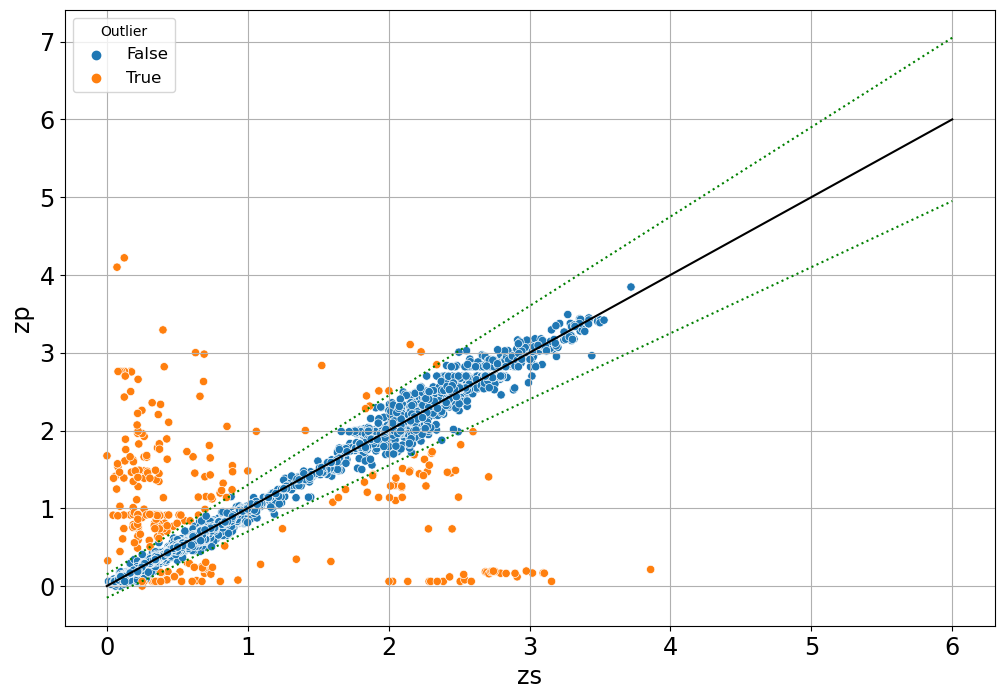

In [32]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_cosLePhare, x='zs', y='zp', hue='Outlier', ax=a)
a.plot(np.arange(0,7), np.arange(0,7)+0.15*(1+np.arange(0,7)), c='g', ls=':')
a.plot(np.arange(0,7), np.arange(0,7)-0.15*(1+np.arange(0,7)), c='g', ls=':')
a.plot(np.arange(0,7), np.arange(0,7), c='k')
a.grid()

38 38 32


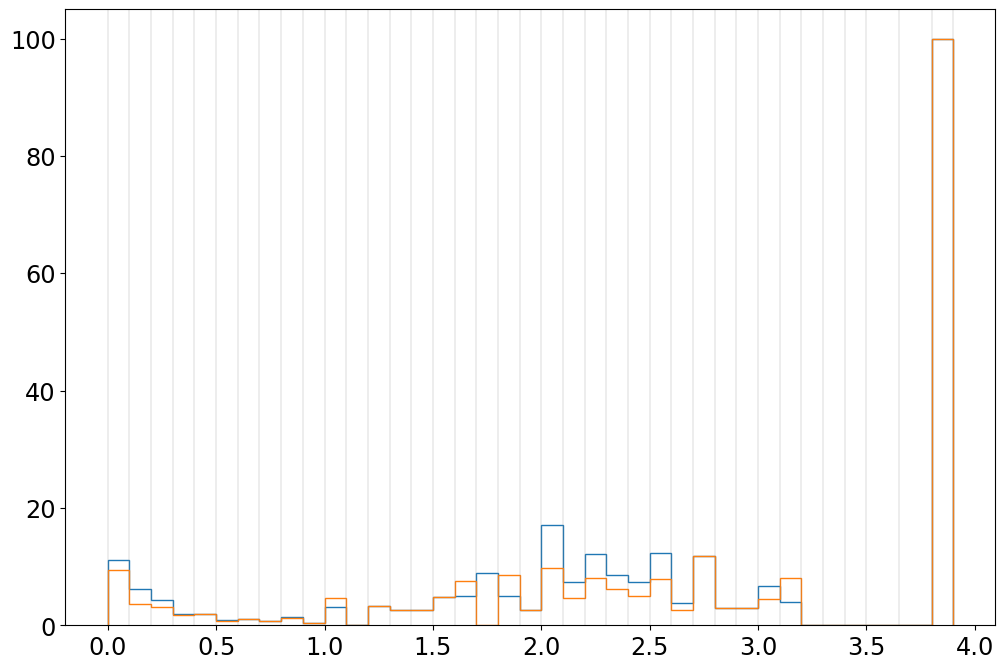

In [33]:
_binEdges = np.arange(0., 4.1, 0.1)
_countsTot, _binsTot = np.histogram(df_resLePhare['zs'], bins=_binEdges)
_countsOut, _binsOut = np.histogram(df_resLePhare['zs_Outlier'], bins=_binsTot)
_sel = (_countsTot > 0.)
outlier_ratios = _countsOut[_sel] / _countsTot[_sel]
_binCenters = 0.5*(_binsTot[:-1]+_binsTot[1:])

binCenters = _binCenters[_sel]
new_binEdges = 0.5*(binCenters[:-1]+binCenters[1:])
new_binEdges = np.append(new_binEdges, binCenters[-1]+(binCenters[-1]-new_binEdges[-1]))
new_binEdges = np.append(binCenters[0]-(new_binEdges[0]-binCenters[0]), new_binEdges)


_countsTot, _binsTot = np.histogram(df_cosLePhare['zs'], bins=new_binEdges)
_countsOut, _binsOut = np.histogram(df_cosLePhare['zs_Outlier'], bins=new_binEdges)
outlierCOS_ratios = _countsOut / _countsTot

plt.stairs(outlier_ratios*100., new_binEdges, label="FORS2")
plt.stairs(outlierCOS_ratios*100., new_binEdges, label="COSMOS")

_sel2 = (outlier_ratios > 0.)
print(len(outlier_ratios), len(_countsTot), len(outlier_ratios[_sel2]))
for edge in new_binEdges:
    plt.axvline(edge, c='grey', linewidth=.2)

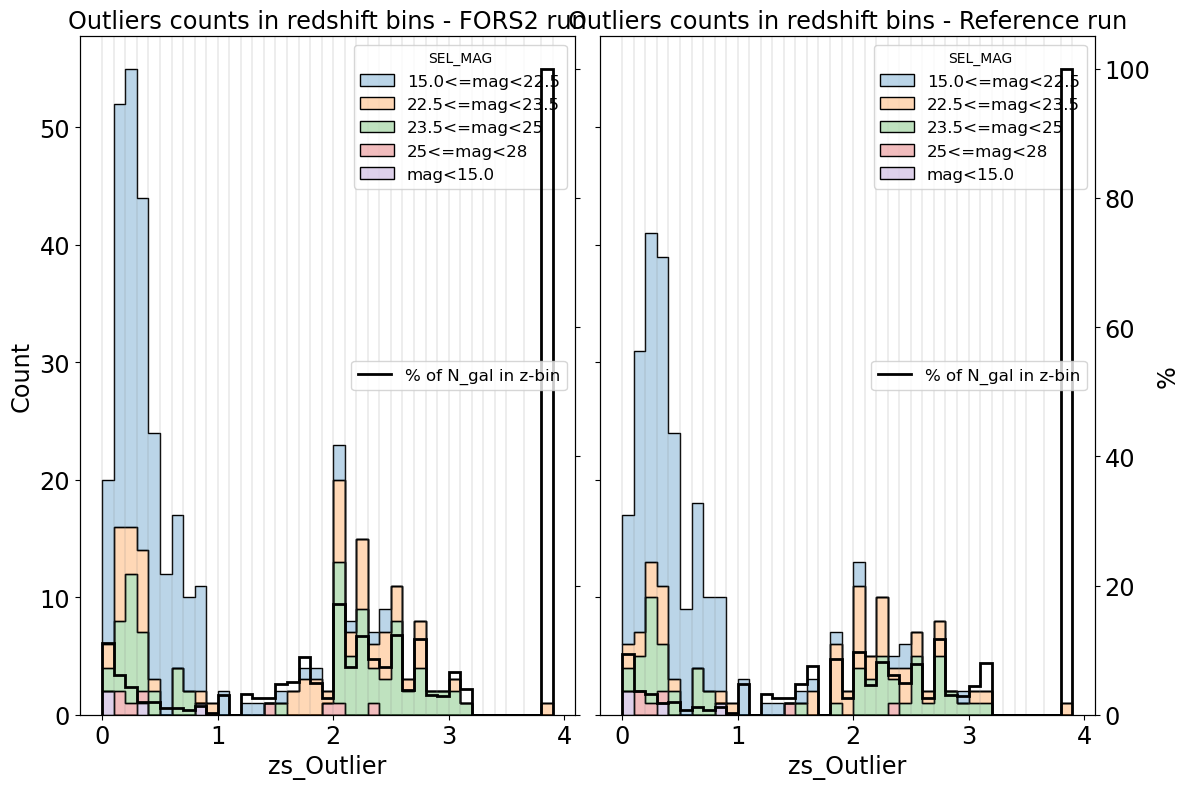

In [34]:
f,a = plt.subplots(1,2, sharey='row')

a01=a[0].twinx()
a01.tick_params(labelright=False)
a01.stairs(outlier_ratios*100., new_binEdges, lw=2., color='k', label="% of N_gal in z-bin")
sns.histplot(data=df_resLePhare, x='zs_Outlier', hue='SEL_MAG',\
             bins=new_binEdges, stat='count', element='step', multiple='stack',\
             ax=a[0], alpha=0.3)#, log_scale=(False,True))

for edge in new_binEdges:
    a[0].axvline(edge, c='grey', linewidth=.2)


a11=a[1].twinx()
a11.stairs(outlierCOS_ratios*100., new_binEdges, lw=2., color='k', label="% of N_gal in z-bin")
sns.histplot(data=df_cosLePhare, x='zs_Outlier', hue='SEL_MAG',\
             bins=new_binEdges, stat='count', element='step', multiple='stack',\
             ax=a[1], alpha=0.3)#, log_scale=(False,True))

for edge in new_binEdges:
    a[1].axvline(edge, c='grey', linewidth=.2)
    
a[0].set_title('Outliers counts in redshift bins - FORS2 run')
#a[0].grid(which='both', axis='y')
a[1].set_title('Outliers counts in redshift bins - Reference run')
#a[1].grid(which='both', axis='y')
a01.legend(loc='center right')
a11.set_ylabel('%')
a11.legend(loc='center right')
f.set_tight_layout(True)

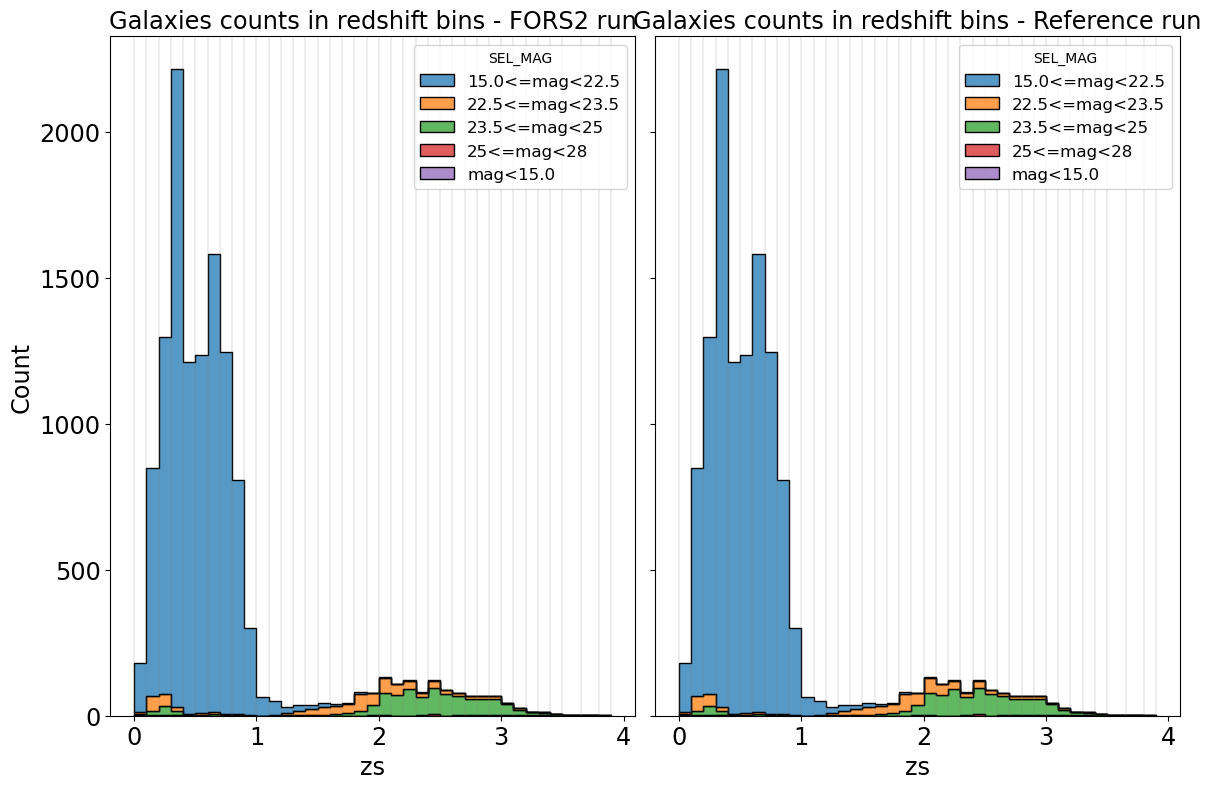

In [35]:
f,a = plt.subplots(1,2, sharey='row')
sns.histplot(data=df_resLePhare, x='zs', hue='SEL_MAG',\
             bins=new_binEdges, stat='count', element='step', multiple='stack',\
             ax=a[0])#, log_scale=(False,True))

for edge in new_binEdges:
    a[0].axvline(edge, c='grey', linewidth=.2)
    
sns.histplot(data=df_cosLePhare, x='zs', hue='SEL_MAG',\
             bins=new_binEdges, stat='count', element='step', multiple='stack',\
             ax=a[1])#, log_scale=(False,True))

for edge in new_binEdges:
    a[1].axvline(edge, c='grey', linewidth=.2)
    
a[0].set_title('Galaxies counts in redshift bins - FORS2 run')
a[1].set_title('Galaxies counts in redshift bins - Reference run')
f.set_tight_layout(True)

38 38 33


/tmp/ipykernel_1481/727330510.py:16: RuntimeWarning: invalid value encountered in divide
  outlierCOS_ratios = _countsOut / _countsTot


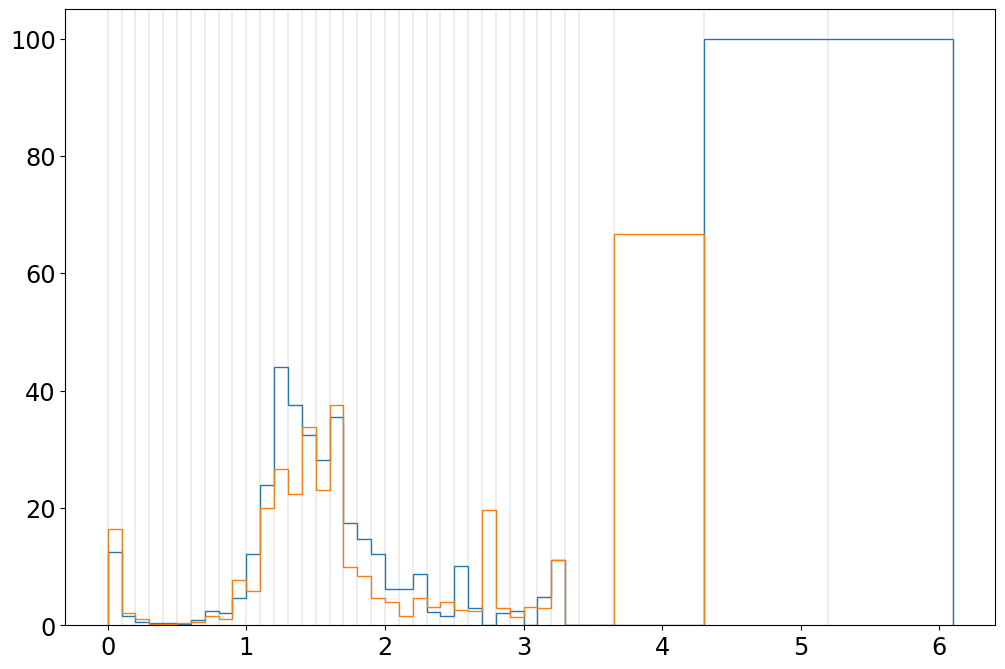

In [36]:
_binEdges = np.arange(0., 6.5, 0.1)
_countsTot, _binsTot = np.histogram(df_resLePhare['zp'], bins=_binEdges)
_countsOut, _binsOut = np.histogram(df_resLePhare['zp_Outlier'], bins=_binsTot)
_sel = (_countsTot > 0.)
outlier_ratios = _countsOut[_sel] / _countsTot[_sel]
_binCenters = 0.5*(_binsTot[:-1]+_binsTot[1:])

binCenters = _binCenters[_sel]
new_binEdges = 0.5*(binCenters[:-1]+binCenters[1:])
new_binEdges = np.append(new_binEdges, binCenters[-1]+(binCenters[-1]-new_binEdges[-1]))
new_binEdges = np.append(binCenters[0]-(new_binEdges[0]-binCenters[0]), new_binEdges)


_countsTot, _binsTot = np.histogram(df_cosLePhare['zp'], bins=new_binEdges)
_countsOut, _binsOut = np.histogram(df_cosLePhare['zp_Outlier'], bins=new_binEdges)
outlierCOS_ratios = _countsOut / _countsTot

plt.stairs(outlier_ratios*100., new_binEdges, label="FORS2")
plt.stairs(outlierCOS_ratios*100., new_binEdges, label="COSMOS")

_sel2 = (outlier_ratios > 0.)
print(len(outlier_ratios), len(_countsTot), len(outlier_ratios[_sel2]))
for edge in new_binEdges:
    plt.axvline(edge, c='grey', linewidth=.2)

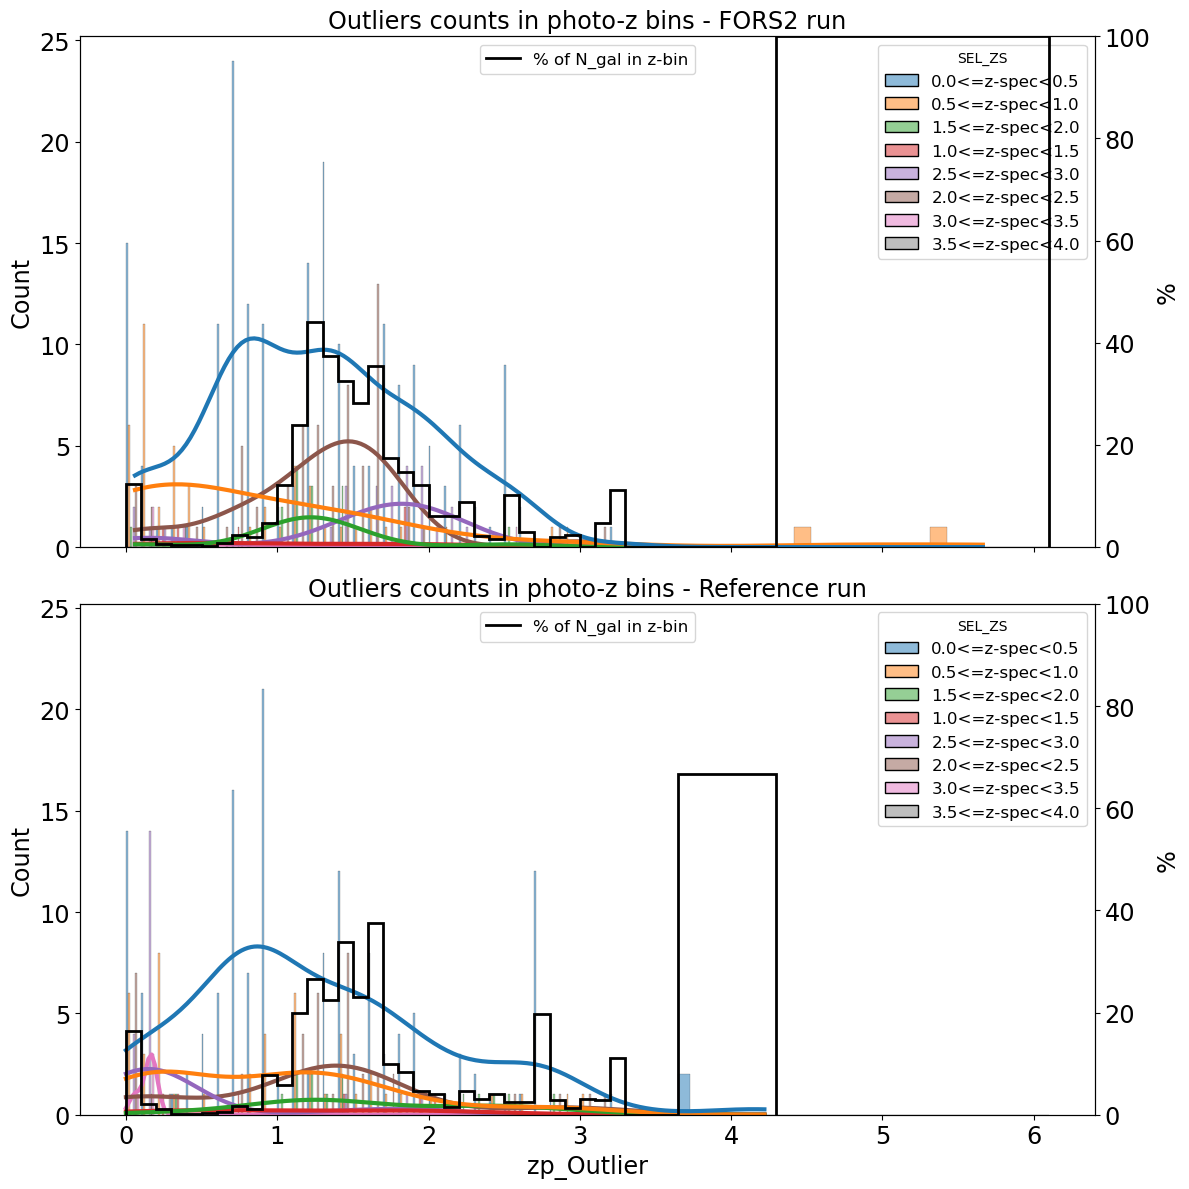

In [37]:
f,a = plt.subplots(2,1, sharex='col', sharey='all', figsize=(12, 12))

a01=a[0].twinx()
#a01.tick_params(labelright=False)
a01.stairs(outlier_ratios*100., new_binEdges, lw=2., color='k', label="% of N_gal in z-bin")
sns.histplot(data=df_resLePhare, x='zp_Outlier', hue='SEL_ZS',\
             bins=new_binEdges, stat='count', multiple='dodge',\
             kde=True, line_kws = {'linewidth':3},\
             ax=a[0])#, alpha=0.3)#, log_scale=(False,True))

#for edge in new_binEdges:
    #a[0].axvline(edge, c='grey', linewidth=.2)


a11=a[1].twinx()
a11.stairs(outlierCOS_ratios*100., new_binEdges, lw=2., color='k', label="% of N_gal in z-bin")
sns.histplot(data=df_cosLePhare, x='zp_Outlier', hue='SEL_ZS',\
             bins=new_binEdges, stat='count', multiple='dodge',\
             kde=True, line_kws = {'linewidth':3},\
             ax=a[1])#, alpha=0.3)#, log_scale=(False,True))

#for edge in new_binEdges:
    #a[1].axvline(edge, c='grey', linewidth=.2)
    
a[0].set_title('Outliers counts in photo-z bins - FORS2 run')
#a[0].grid(which='both', axis='y')
a[1].set_title('Outliers counts in photo-z bins - Reference run')
#a[1].grid(which='both', axis='y')
a01.legend(loc='upper center')
a01.set_ylabel('%')
a01.set_ylim(0., 100.)
a11.set_ylabel('%')
a11.set_ylim(0., 100.)
a11.legend(loc='upper center')
f.set_tight_layout(True)

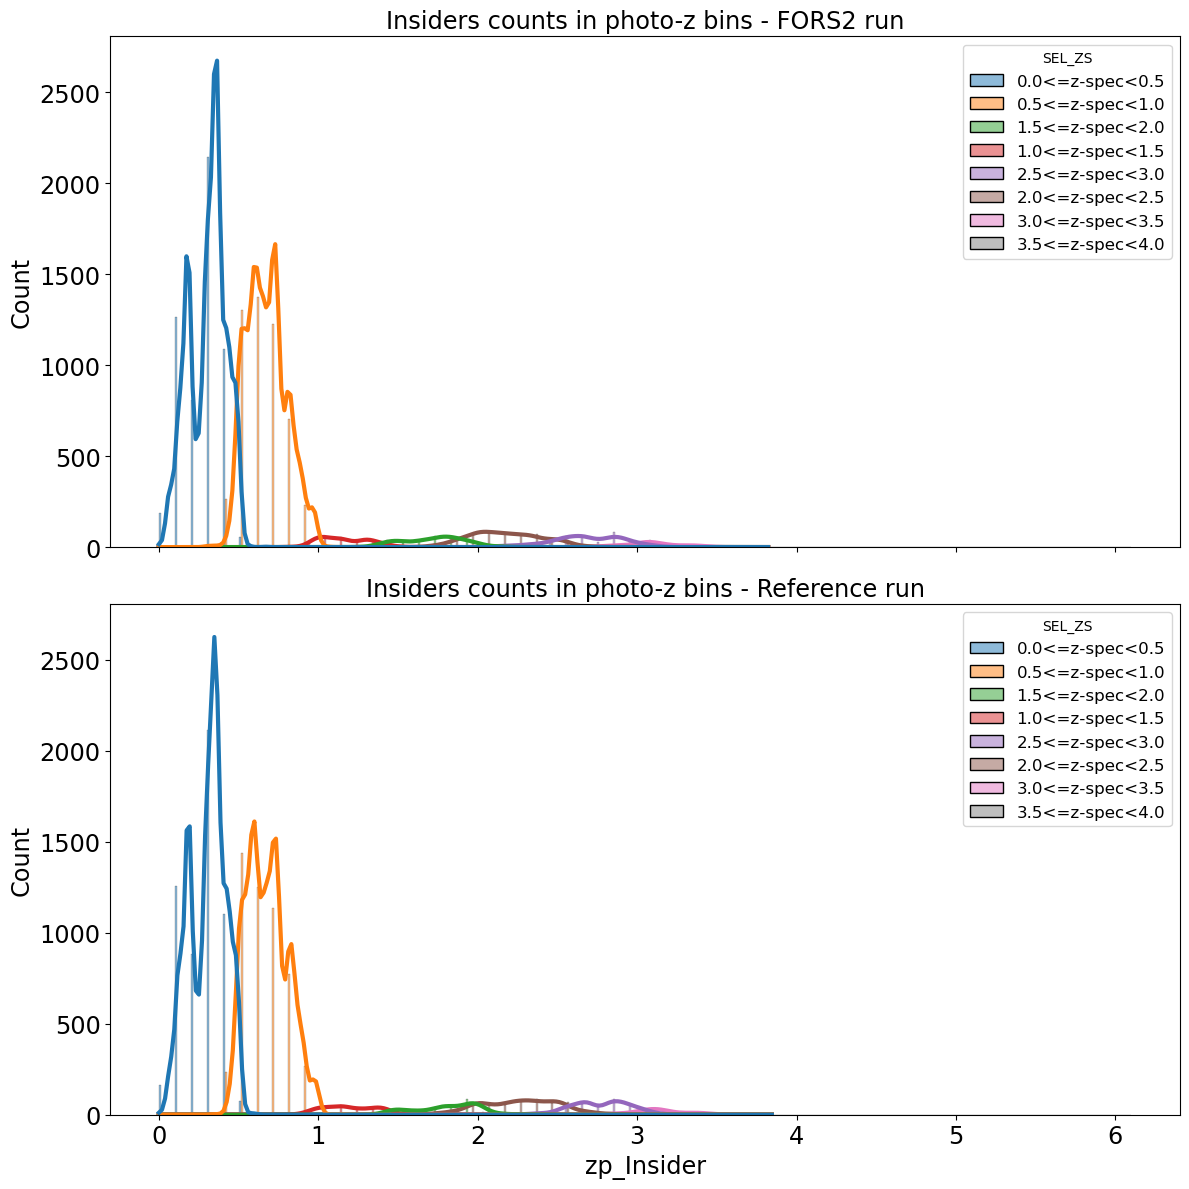

In [38]:
f,a = plt.subplots(2,1, sharex='col', sharey='all', figsize=(12, 12))

sns.histplot(data=df_resLePhare, x='zp_Insider', hue='SEL_ZS',\
             bins=new_binEdges, stat='count', multiple='dodge',\
             kde=True, line_kws = {'linewidth':3},\
             ax=a[0])#, alpha=0.3)#, log_scale=(False,True))

#for edge in new_binEdges:
    #a[0].axvline(edge, c='grey', linewidth=.2)


sns.histplot(data=df_cosLePhare, x='zp_Insider', hue='SEL_ZS',\
             bins=new_binEdges, stat='count', multiple='dodge',\
             kde=True, line_kws = {'linewidth':3},\
             ax=a[1])#, alpha=0.3)#, log_scale=(False,True))

#for edge in new_binEdges:
    #a[1].axvline(edge, c='grey', linewidth=.2)
    
a[0].set_title('Insiders counts in photo-z bins - FORS2 run')
#a[0].grid(which='both', axis='y')
a[1].set_title('Insiders counts in photo-z bins - Reference run')
#a[1].grid(which='both', axis='y')
a01.legend(loc='upper center')
a01.set_ylabel('%')
a11.set_ylabel('%')
a11.legend(loc='upper center')
f.set_tight_layout(True)

## Identifier les cas qui plantent avec FORS2 mais pas en référence

In [39]:
_sel = df_resLePhare['Outlier'] * [not b for b in np.array(df_cosLePhare['Outlier'])]
df_resLePhare.index[_sel]

Int64Index([    3,   100,   107,   210,   376,   428,   661,   698,   817,
              894,
            ...
            11173, 11244, 11245, 11775, 11826, 11980, 12019, 12043, 12147,
            12304],
           dtype='int64', length=119)

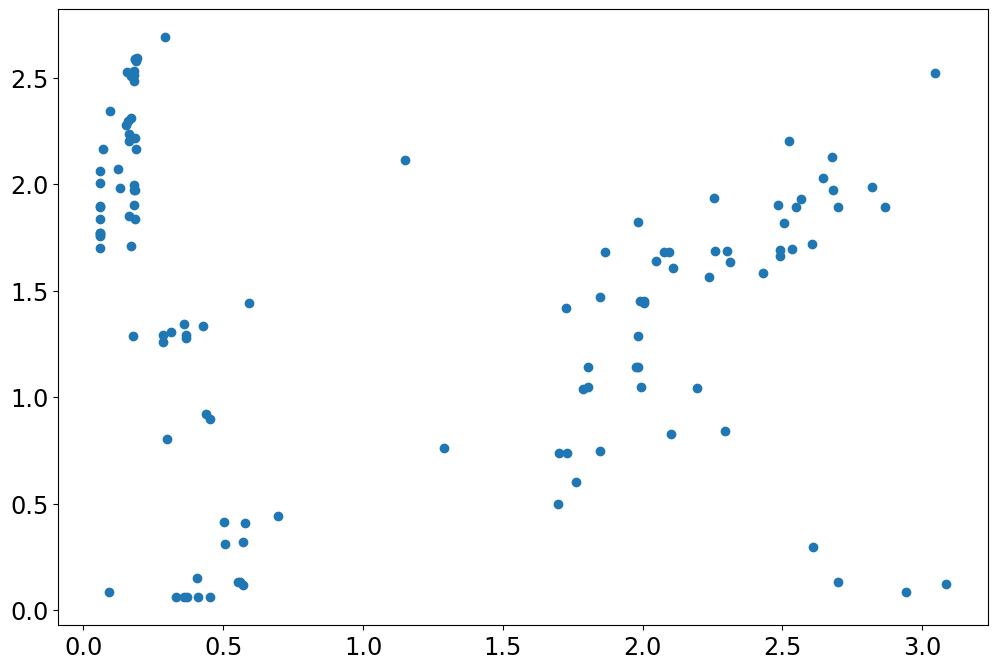

In [40]:
plt.scatter(df_cosLePhare['zp'][_sel], df_resLePhare['zp'][_sel])

In [41]:
df_diffFors2Ref = pd.DataFrame(index = df_resLePhare.index[_sel])
df_diffFors2Ref['zs'] = df_resLePhare['zs'][_sel]
df_diffFors2Ref['SEL_ZS'] = df_resLePhare['SEL_ZS'][_sel]
df_diffFors2Ref['zp_fors2'] = df_resLePhare['zp'][_sel]
df_diffFors2Ref['zp_ref'] = df_cosLePhare['zp'][_sel]

df_diffFors2Ref['SEL_MAG_fors2'] = df_resLePhare['SEL_MAG'][_sel]
df_diffFors2Ref['SEL_MAG_ref'] = df_cosLePhare['SEL_MAG'][_sel]


df_diffFors2Ref['chi_fors2'] = df_resLePhare['chi'][_sel]
df_diffFors2Ref['chi_ref'] = df_cosLePhare['chi'][_sel]

df_diffFors2Ref['mod_fors2'] = df_resLePhare['mod'][_sel]
df_diffFors2Ref['mod_ref'] = df_cosLePhare['mod'][_sel]

df_diffFors2Ref['law_fors2'] = df_resLePhare['law'][_sel]
df_diffFors2Ref['law_ref'] = df_cosLePhare['law'][_sel]

df_diffFors2Ref['ebv_fors2'] = df_resLePhare['ebv'][_sel]
df_diffFors2Ref['ebv_ref'] = df_cosLePhare['ebv'][_sel]

df_diffFors2Ref['deltaZs_fors2'] = np.abs(df_diffFors2Ref['zp_fors2'] - df_diffFors2Ref['zs'])/(1+df_diffFors2Ref['zs'])
df_diffFors2Ref['deltaZs_ref'] = np.abs(df_diffFors2Ref['zp_ref'] - df_diffFors2Ref['zs'])/(1+df_diffFors2Ref['zs'])

In [42]:
df_diffFors2Ref

,zs,SEL_ZS,zp_fors2,zp_ref,SEL_MAG_fors2,SEL_MAG_ref,chi_fors2,chi_ref,mod_fors2,mod_ref,law_fors2,law_ref,ebv_fors2,ebv_ref,deltaZs_fors2,deltaZs_ref
3,0.5186,0.5<=z-spec<1.0,0.0600,0.4530,15.0<=mag<22.5,15.0<=mag<22.5,699.171,695.988,16.0,25.0,0.0,0.0,0.00,0.00,0.301989,0.043198
100,0.1459,0.0<=z-spec<0.5,2.2770,0.1529,15.0<=mag<22.5,15.0<=mag<22.5,250.645,340.637,83.0,23.0,0.0,0.0,0.20,0.00,1.859761,0.006109
107,0.4293,0.0<=z-spec<0.5,1.3320,0.4274,15.0<=mag<22.5,15.0<=mag<22.5,710.273,757.235,83.0,27.0,0.0,3.0,0.35,0.05,0.631568,0.001329
210,0.5710,0.5<=z-spec<1.0,0.3103,0.5060,15.0<=mag<22.5,15.0<=mag<22.5,205.929,306.341,16.0,25.0,0.0,0.0,0.00,0.15,0.165945,0.041375
376,0.2033,0.0<=z-spec<0.5,1.9740,0.1817,15.0<=mag<22.5,15.0<=mag<22.5,186.876,206.587,80.0,27.0,0.0,1.0,0.25,0.25,1.471537,0.017951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11980,0.3488,0.0<=z-spec<0.5,0.8049,0.2996,15.0<=mag<22.5,15.0<=mag<22.5,4134.650,4840.830,60.0,7.0,0.0,0.0,0.00,0.00,0.338152,0.036477
12019,0.1511,0.0<=z-spec<0.5,2.3120,0.1702,15.0<=mag<22.5,15.0<=mag<22.5,215.853,287.760,83.0,23.0,0.0,0.0,0.20,0.00,1.877248,0.016593
12043,0.2291,0.0<=z-spec<0.5,2.5770,0.1874,15.0<=mag<22.5,15.0<=mag<22.5,687.543,689.276,34.0,27.0,0.0,0.0,0.25,0.00,1.910260,0.033927
12147,0.2167,0.0<=z-spec<0.5,2.5900,0.1924,15.0<=mag<22.5,15.0<=mag<22.5,156.231,149.888,80.0,21.0,0.0,0.0,0.20,0.05,1.950604,0.019972


<AxesSubplot: xlabel='zp_ref', ylabel='zp_fors2'>

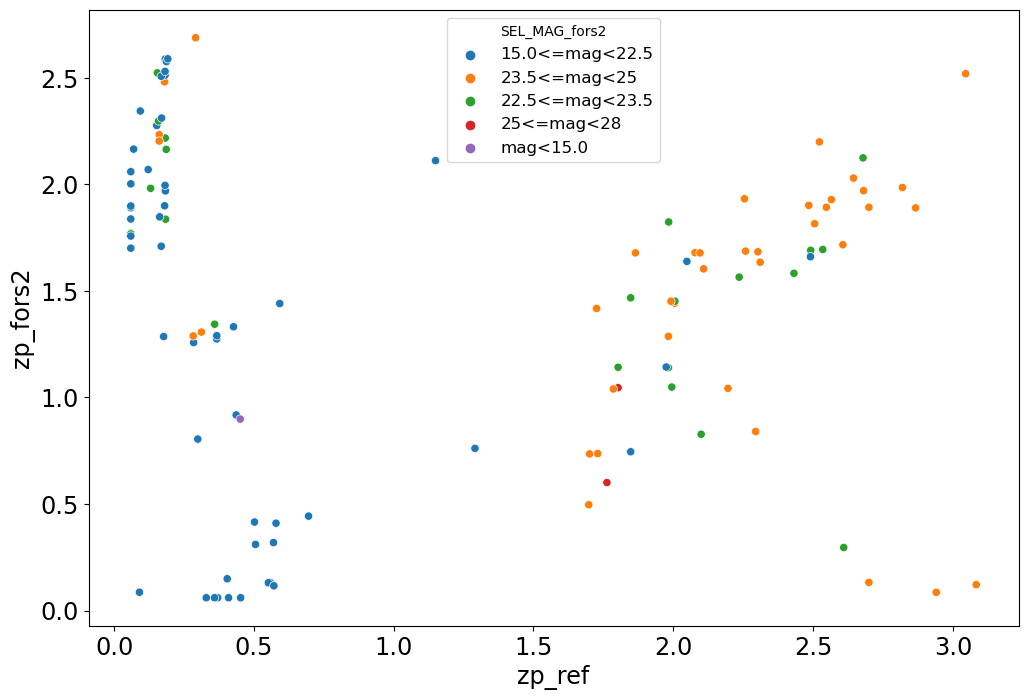

In [43]:
sns.scatterplot(data=df_diffFors2Ref, x='zp_ref', y='zp_fors2', hue='SEL_MAG_fors2')

<AxesSubplot: xlabel='zp_ref', ylabel='zp_fors2'>

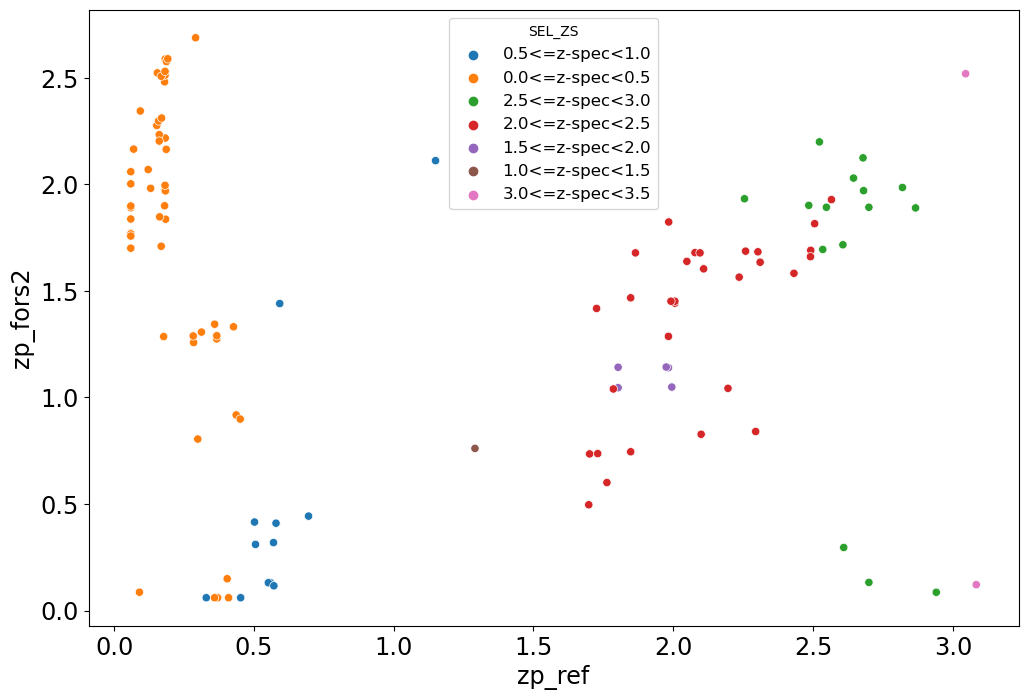

In [44]:
sns.scatterplot(data=df_diffFors2Ref, x='zp_ref', y='zp_fors2', hue='SEL_ZS')

<AxesSubplot: xlabel='deltaZs_ref', ylabel='deltaZs_fors2'>

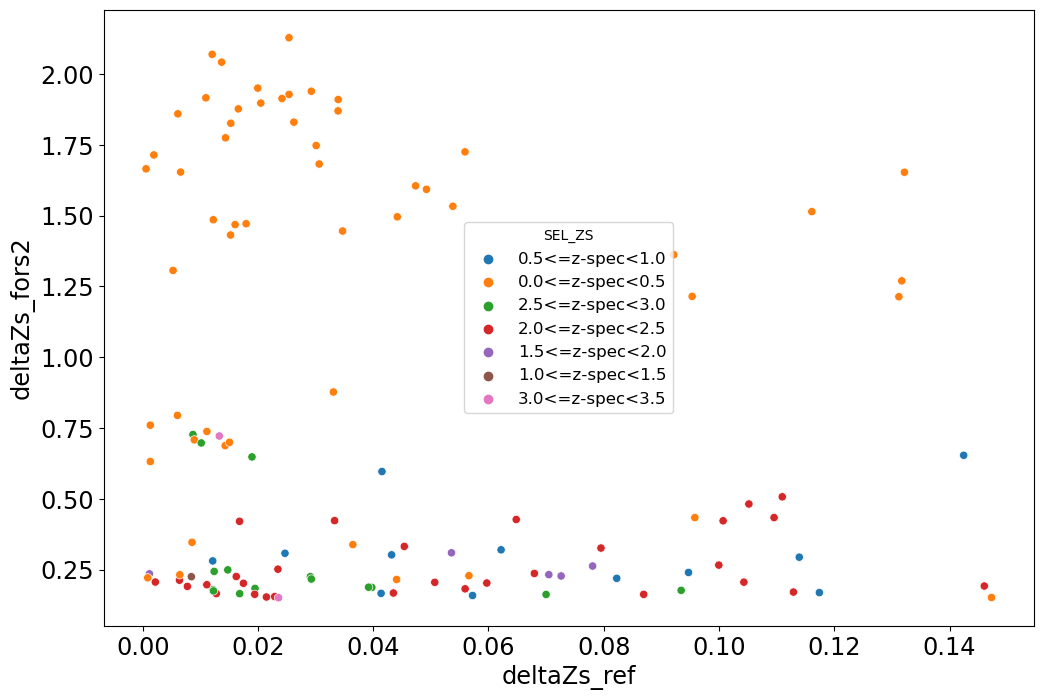

In [45]:
sns.scatterplot(data=df_diffFors2Ref, x='deltaZs_ref', y='deltaZs_fors2', hue='SEL_ZS')

## Créer l'input pour LePhare pour les cas conflictuels

Afin de lancer LePhare avec **SPEC_OUT** pour les cas sélectionnés et identifier d'éventuelles cause d'échec.

In [46]:
lephare_dir = 'LEPHARE'
if os.getenv('LEPHAREDIR') is not None:
    lephare_path = os.environ['LEPHAREDIR']
else:
    lephare_path = os.path.abspath(os.path.join(os.getcwd(),lephare_dir))
    os.environ['LEPHAREDIR'] = lephare_path

input_dir = 'examples'
ref_input_file = 'COSMOS.in'

path_to_ref = os.path.join(lephare_path, input_dir, ref_input_file)
path_to_ref

'/home/joseph/PhotoZ_PhD/LEPHARE/examples/COSMOS.in'

### Méthode 1: numpy array
Ne conserve pas le format

In [47]:
if False:
    ref_array = np.loadtxt(path_to_ref)
    _sel = df_resLePhare['Outlier'] * [not b for b in np.array(df_cosLePhare['Outlier'])]
    sel_array = ref_array[_sel, :]
    _path = os.path.join(lephare_res_path, 'outliers_Kmean.in')
    np.savetxt(_path, sel_array)

### Méthode 2: recopie des lignes du fichier d'origine
Moins immédiat mais format identique

In [48]:
if False:
    out_file = os.path.join(lephare_res_path, 'outliers_Kmean.in')
    with open(path_to_ref, 'r') as fin:
        _lines = fin.readlines()

    with open(out_file, 'w') as fout:
        fout.write(_lines[0])

    with open(out_file, 'a') as fout:
        for line in _lines[1:]:
            _idx = int(line.split(' ')[0])
            if _idx in list(df_diffFors2Ref.index):
                fout.write(line)

## Identification des différences entre les runs

In [49]:
specOut_dir_fors2 = 'SPEC_OUT_outliers_fors2_SL'
specOut_dir_ref = 'SPEC_OUT_outliers_ref'